In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [2]:
# Temizlenmiş ana veri setini yükleyelim
df = pd.read_csv("crime_data_clean_azra.csv")
df.head()


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,LOCATION,LAT,LON
0,211507896,2021-04-11,2020-11-07,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,501.0,SINGLE FAMILY DWELLING,-1.0,UNKNOWN,IC,Invest Cont,354.0,7800 BEEMAN AV,34.2124,-118.4092
1,201516622,2020-10-21,2020-10-18,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,102.0,SIDEWALK,200.0,KNIFE WITH BLADE 6INCHES OR LESS,IC,Invest Cont,230.0,ATOLL AV,34.1993,-118.4203
2,210704711,2020-12-24,2020-12-24,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,101.0,STREET,-1.0,UNKNOWN,IC,Invest Cont,331.0,6000 COMEY AV,34.0339,-118.3747
3,201418201,2020-10-03,2020-09-29,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,103.0,ALLEY,-1.0,UNKNOWN,IC,Invest Cont,420.0,4700 LA VILLA MARINA,33.9813,-118.4350
4,201115217,2020-10-29,2020-07-07,1400,11,Northeast,1133,2,812,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,...,121.0,YARD (RESIDENTIAL/BUSINESS),500.0,UNKNOWN WEAPON/OTHER WEAPON,AO,Adult Other,812.0,3000 ACRESITE ST,34.1107,-118.2589


In [3]:
# DATE OCC'i datetime yap
df["DATE OCC"] = pd.to_datetime(df["DATE OCC"], errors="coerce")

# Year-Month (ym) kolonu
df["ym"] = df["DATE OCC"].dt.to_period("M").astype(str)

# Aylık suç sayısı
monthly_counts = df.groupby("ym").size().reset_index(name="crime_count")

# Rolling window özellikleri
monthly_counts["rolling_3"] = monthly_counts["crime_count"].rolling(3).sum()
monthly_counts["rolling_6"] = monthly_counts["crime_count"].rolling(6).sum()
monthly_counts["rolling_12"] = monthly_counts["crime_count"].rolling(12).sum()

# Ana df ile birleştir
df = df.merge(monthly_counts, on="ym", how="left")
df.head()


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,LOCATION,LAT,LON,ym,crime_count,rolling_3,rolling_6,rolling_12
0,211507896,2021-04-11,2020-11-07,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,Invest Cont,354.0,7800 BEEMAN AV,34.2124,-118.4092,2020-11,15363,47151.0,97259.0,NaN
1,201516622,2020-10-21,2020-10-18,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,Invest Cont,230.0,ATOLL AV,34.1993,-118.4203,2020-10,16304,48396.0,98823.0,NaN
2,210704711,2020-12-24,2020-12-24,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,Invest Cont,331.0,6000 COMEY AV,34.0339,-118.3747,2020-12,15677,47344.0,96212.0,196059.0
3,201418201,2020-10-03,2020-09-29,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,Invest Cont,420.0,4700 LA VILLA MARINA,33.9813,-118.4350,2020-09,15484,48868.0,97921.0,NaN
4,201115217,2020-10-29,2020-07-07,1400,11,Northeast,1133,2,812,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,...,Adult Other,812.0,3000 ACRESITE ST,34.1107,-118.2589,2020-07,16776,50427.0,98683.0,NaN


In [4]:
# Kullanacağımız özellikler (full model)
feature_cols = [
    "TIME OCC", "LAT", "LON",
    "Vict Age", "Crm Cd",
    "Premis Cd", "Weapon Used Cd",
    "crime_count", "rolling_3", "rolling_6", "rolling_12"
]

X = df[feature_cols]
y = df["Part 1-2"]   # hedef değişkenimiz

X.shape, y.shape


((995231, 11), (995231,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((796184, 11), (199047, 11))

In [8]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
    
    print(f"== {model_name} ==")
    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1-score :", round(f1, 4))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    
    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }


In [7]:
rf_full = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_full.fit(X_train, y_train)
y_pred_full = rf_full.predict(X_test)

results = []
results.append(evaluate_model(y_test, y_pred_full, model_name="RF - Full Features"))


== RF - Full Features ==
Accuracy : 0.9996
Precision: 0.9995
Recall   : 0.9998
F1-score : 0.9997

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00    120009
           2       1.00      1.00      1.00     79038

    accuracy                           1.00    199047
   macro avg       1.00      1.00      1.00    199047
weighted avg       1.00      1.00      1.00    199047

Confusion Matrix:
 [[119990     19]
 [    57  78981]]


In [9]:
# RFE'den gelen feature isimlerini yüklemeyi deneyelim
try:
    with open("rfe_feature_names.pkl", "rb") as f:
        rfe_features = pickle.load(f)
    print("RFE feature sayısı:", len(rfe_features))
    print(rfe_features[:10])
except FileNotFoundError:
    rfe_features = None
    print("rfe_feature_names.pkl bulunamadı, bu modeli atlayacağız.")


RFE feature sayısı: 200
['DR_NO', 'TIME OCC', 'Rpt Dist No', 'Vict Age', 'LAT', 'LON', 'Date Rptd_2020-01-02', 'Date Rptd_2020-01-29', 'Date Rptd_2020-02-28', 'Date Rptd_2020-03-29']


In [10]:
if rfe_features is not None:
    # RFE'de seçilmiş feature'lar X içinde varsa alt setini al
    rfe_features_in_X = [col for col in rfe_features if col in X.columns]
    print("X içinde bulunan RFE feature sayısı:", len(rfe_features_in_X))

    X_train_rfe = X_train[rfe_features_in_X]
    X_test_rfe = X_test[rfe_features_in_X]

    rf_rfe = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf_rfe.fit(X_train_rfe, y_train)
    y_pred_rfe = rf_rfe.predict(X_test_rfe)

    results.append(evaluate_model(y_test, y_pred_rfe, model_name="RF - RFE Features"))


X içinde bulunan RFE feature sayısı: 4
== RF - RFE Features ==
Accuracy : 0.6459
Precision: 0.692
Recall   : 0.7438
F1-score : 0.717

Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.74      0.72    120009
           2       0.56      0.50      0.53     79038

    accuracy                           0.65    199047
   macro avg       0.63      0.62      0.62    199047
weighted avg       0.64      0.65      0.64    199047

Confusion Matrix:
 [[89261 30748]
 [39726 39312]]


In [11]:
try:
    with open("selected_feature_names.pkl", "rb") as f:
        lasso_features = pickle.load(f)
    print("LASSO feature sayısı:", len(lasso_features))
except FileNotFoundError:
    lasso_features = None
    print("selected_feature_names.pkl bulunamadı, LASSO modeli atlanacak.")


LASSO feature sayısı: 98


In [12]:
if lasso_features is not None:
    lasso_features_in_X = [col for col in lasso_features if col in X.columns]
    print("X içinde bulunan LASSO feature sayısı:", len(lasso_features_in_X))

    X_train_lasso = X_train[lasso_features_in_X]
    X_test_lasso = X_test[lasso_features_in_X]

    rf_lasso = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf_lasso.fit(X_train_lasso, y_train)
    y_pred_lasso = rf_lasso.predict(X_test_lasso)

    results.append(evaluate_model(y_test, y_pred_lasso, model_name="RF - LASSO Features"))


X içinde bulunan LASSO feature sayısı: 4
== RF - LASSO Features ==
Accuracy : 0.6459
Precision: 0.692
Recall   : 0.7438
F1-score : 0.717

Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.74      0.72    120009
           2       0.56      0.50      0.53     79038

    accuracy                           0.65    199047
   macro avg       0.63      0.62      0.62    199047
weighted avg       0.64      0.65      0.64    199047

Confusion Matrix:
 [[89261 30748]
 [39725 39313]]


In [14]:

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")  # median en sağlıklı
X_train_filled = imputer.fit_transform(X_train)
X_test_filled = imputer.transform(X_test)


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5, random_state=42)

X_train_pca = pca.fit_transform(X_train_filled)
X_test_pca = pca.transform(X_test_filled)

rf_pca = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_pca.fit(X_train_pca, y_train)
y_pred_pca = rf_pca.predict(X_test_pca)

results.append(
    evaluate_model(y_test, y_pred_pca, model_name="RF - PCA(5) Features")
)


== RF - PCA(5) Features ==
Accuracy : 0.9578
Precision: 0.9615
Recall   : 0.9689
F1-score : 0.9652

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.97      0.97    120009
           2       0.95      0.94      0.95     79038

    accuracy                           0.96    199047
   macro avg       0.96      0.95      0.96    199047
weighted avg       0.96      0.96      0.96    199047

Confusion Matrix:
 [[116273   3736]
 [  4655  74383]]


In [16]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1
0,RF - Full Features,0.999618,0.999525,0.999842,0.999683
1,RF - RFE Features,0.645943,0.692015,0.743786,0.716967
2,RF - LASSO Features,0.645948,0.692021,0.743786,0.716970
3,RF - PCA(5) Features,0.957844,0.961506,0.968869,0.965173


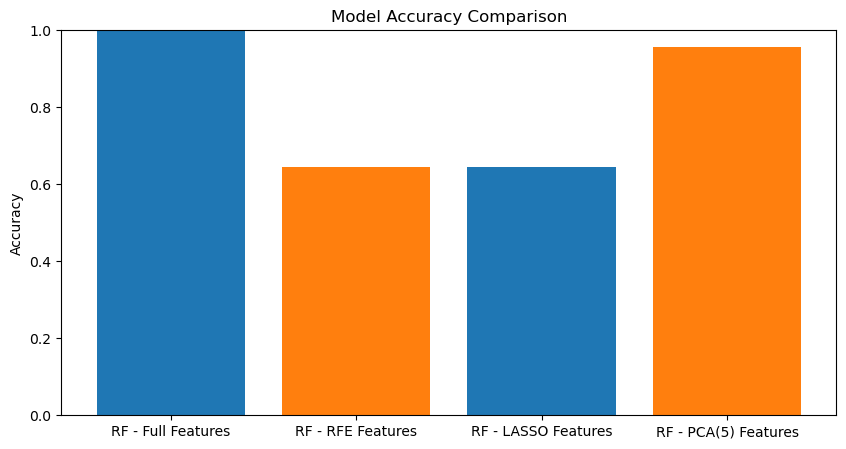

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["Accuracy"], color=["#1f77b4", "#ff7f0e"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


In [18]:
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print("En iyi model:")
print(best_model)


En iyi model:
Model        RF - Full Features
Accuracy               0.999618
Precision              0.999525
Recall                 0.999842
F1                     0.999683
Name: 0, dtype: object
